# Report

## 1. Folder Tree
**Report.ipynb** - Describing the algorithm of Multi-Agent DDPG(MADDPG) for solving the "Tennis" task.

**main.ipynb** - Containing the training code of the MADDPG algorithm and showing the return of each episode along the 
training step.

**model.py&utils.py** - Containing the network architechture

**MADDPG.ckpt** - The trained model weights.

**MADDPG_max_scores.csv** - results.

## 2. Approach
Due to the fact that it is often unstable to train multiple agent in a environment. I implement the MADDPG algorithm that partly solve this problem. MADDPG is extended from the DDPG algorithm, and constructed by Actor-Critic architecture. The diffrence between them is use the so called "decentralized actor" with the "centralized critic", which better fit the multi agent problem, see figure below.
<img src='figure/multi-agent-actor-critic.png' width=30% height=30%>
Next, I will discussed my implementation of this algorithm.

### 2.1 Actor-Critic
First, I create two decentralized actor and a centralized critic along with their target networks for two agent. The code can be found in "Agent" class of model.py.
```python
        self.actor_local_0 = Actor(state_size, action_size, embed_dim, seed).to(
            device)
        self.actor_target_0 = Actor(state_size, action_size, embed_dim, seed).to(
            device)
        self.actor_optimizer_0 = optim.Adam(self.actor_local_0.parameters(), lr=lr)

        self.actor_local_1 = Actor(state_size, action_size, embed_dim, seed).to(
            device)
        self.actor_target_1 = Actor(state_size, action_size, embed_dim, seed).to(
            device)
        self.actor_optimizer_1 = optim.Adam(self.actor_local_1.parameters(), lr=lr)

        self.critic_local = Critic(2 * state_size, 2 * action_size, embed_dim, seed).to(
            device)
        self.critic_target = Critic(2 * state_size, 2 * action_size, embed_dim, seed).to(
            device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=lr)
```

### 2.2 Time-Correlated Replay Buffer
In the last two project, we often save one step experience like (S, A, R, S') to the replay buffer, and then randomly sample a batch from the replay buffer to train the agent. This implementation may suit for one-step TD update algorithm. However, whatif we want to implement n-step TD($\gamma$) algorithm to better trade off the bias and variance of the estamation of the Q value. So in my case, I implement a time-correlated replay buffer, which imply that the agent save a continuous episode at a time in the replay buffer, and then sample the whole experiences at the training time to train the model. Note, in my implementation, I find it is good enough to train the model using one-step TD learning, so n-step TD learning can be the future work, which may perform better.

### 2.3 Hyperparameters

#### Ornstein-Uhlenbeck process
I addressed the exploration and exploitation dilemma using the Ornstein-Uhlenbeck process, which add a certain noise to the action at each timestep. The characteristic of the OU process is that its noise is dependent on the previous timestep, which is infected by three parameters:

1) $\mu$: the long-running mean. Default: 0

2) $\theta$: the speed of mean reversion. Default: 0.15

3) $\sigma$: the volatility parameter. Default: 0.2

Furthermore, we linearly decay the noise for more exploitation and less exploration throungh the training process. 

```python
EPS_START = 5.0   # initial value for epsilon in noise decay process in Agent.act()
EPS_EP_END = 500  # episode to end the noise decay process
EPS_FINAL = 0     # final value for epsilon after decay
```
#### Other hyperparameters
```python
BATCH_SIZE = 16         # Batch size of training samples.
EMBED_DIM = 256         # Embed size of the agent.
NUM_EPISODES = 2500     # Maximum training episodes.
LOG_INTERVAL = 128      # The interval to print the average scores
LEARN_NUM = 16          # Learning times at each episode.
BUFFER_SIZE = int(1e6)  # The buffer size of the replay buffer.
```

## 3. Experimental Results

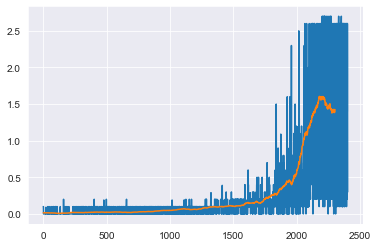

The maximum average scores is 1.60


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


# Load experimental results.
scores = pd.read_csv('MADDPG_max_scores.csv')['0'].values

# Visualize the return curve.
avg_scores = []
for i in range(100, len(scores)):
    avg_scores.append(np.mean(scores[i-100:i]))
    
plt.plot(scores)
plt.plot(avg_scores)
plt.grid(True)
plt.show()

# Analize the results.
print(f'The maximum average scores is {np.max(avg_scores):.2f}')

From the figure, we can see that our agent accomplished an average score of 1.60. And it first hit an average score of +0.5 at around 2000 episodes. To this end, we solve this task!

## Future work
**1. N-step TD Learning**

I have implemented a time time-correlated replay buffer, so I can use a n-step return to estimate the value funciton, which may find a better trade off between bias and variance than one-step return. Here is the definition of the n-step return:

$G_{t:t+n}=R_t + \gamma R_{t+1} + ... + \gamma^{n-1} R_{t+n} + \gamma^{n} V_{t+n}$

**2. Prioritized Experience Replay**

Instead of sample experiences randomly, we can perform prioritized experience replay (PER). PER samples the experiences depending on their importance, which is correlated to the TD-error. The higher the TD-error, the more likely it is to be sampled. Therefore, by performing the PER, the agent may become more efficient to learn in environment.

# Visualization of Agent Play Tennis

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="./Tennis.app")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [3]:
%load_ext autoreload
%autoreload 2
from model import Agent
from tqdm import tqdm
import torch

BATCH_SIZE = 16         # Batch size of training samples.
EMBED_DIM = 256         # Embed size of the agent.
NUM_EPISODES = 2500     # Maximum training episodes.
LOG_INTERVAL = 128      # The interval to print the average scores
LEARN_NUM = 16          # Learning times at each episode.
BUFFER_SIZE = int(1e6)  # The buffer size of the replay buffer.

agent = Agent(state_size, action_size, buffer_size=BUFFER_SIZE)
ckpt = torch.load('./MADDPG.ckpt')
agent.load_state_dict(ckpt['agent'])

<All keys matched successfully>

In [ ]:
NUM_EPISODES = 5

with tqdm(total=NUM_EPISODES) as pbar:
    for i_episode in range(NUM_EPISODES):
        pbar.update(1)
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = agent.act(states, isnoise=False)         # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = np.array(env_info.rewards)               # get reward (for each agent)
            dones = np.array(env_info.local_done)              # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            
            states = next_states
            if np.any(dones):                                  # exit loop if episode finished
                break

 60%|██████    | 3/5 [02:59<01:55, 57.95s/it]

<img src="figure/MultiAgentPlayTennis.gif" width="70%" align="top-left" alt="" title="Robot Ping Pong" />